# EURUSD prediction

## Dependencies

In [1]:
from database_operations.DatabaseManager import DatabaseManager
from scripts.HistoricalDataCollector import HistoricalDataCollector
from xapi import PeriodCode
from my_secrets import config

import pandas as pd

### Connection to database and define symbol

In [2]:
SYMBOL = "EURUSD"
database_conn = DatabaseManager(config.DB_FILE)

In [3]:
SYMBOL_ID  = await database_conn.get_specify_data("stock",["id"], f"symbol = ?",(SYMBOL,))
SYMBOL_ID = SYMBOL_ID[0][0]

Connected to db.
Set row factory.


## Download newest EURUSD data and save in db

In [5]:
hist_data_collector = HistoricalDataCollector(
    symbol= SYMBOL,
    start='2000-01-01',
    end='2023-10-10',
    period=PeriodCode.PERIOD_D1,
    credentials_file=config.CREDENTIALS_PATH
)
await hist_data_collector.connect_to_xapi()
await database_conn.populate_prices("stock_price_1d", SYMBOL_ID, SYMBOL, hist_data_collector)

Connected to API.
Last date in the database
2023-10-10 00:00:00
Today's date
2023-10-12 00:00:00
Newest data downloaded
Data for symbol: EURUSD just added to the database.
Disconnected from db.


## Download data from db

In [6]:
COLUMNS = ['date', 'open', 'close', 'high', 'low', 'volume']
columns_with_prefix = [f'sp.{column}' for column in COLUMNS]
columns_list = ', '.join(columns_with_prefix)

In [7]:
QUERY = f"""
        SELECT {columns_list}
        FROM stock s
        JOIN stock_price_1d sp ON s.id = sp.stock_id
        WHERE s.symbol = ?
        """

In [8]:
data_list = await database_conn.execute_custom_query(QUERY, (SYMBOL,))

Connected to db.
Set row factory.


## Create dataframe

In [9]:
data_df = pd.DataFrame(data_list, columns=COLUMNS)

In [10]:
data_df['date'] = data_df['date'].str.split(' ').str[0]

In [11]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [12]:
data_df.set_index('date',inplace=True)

<Axes: xlabel='date'>

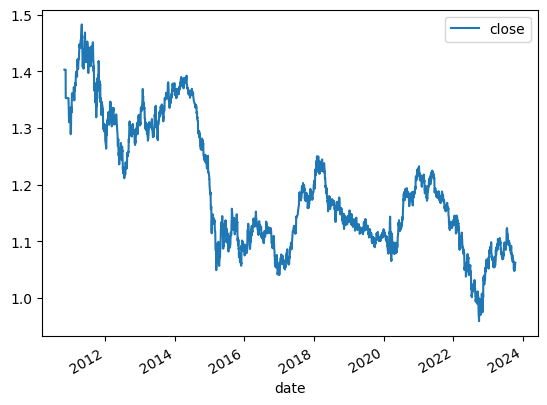

In [14]:
data_df.plot.line(y="close",use_index=True)

# Reinforcement Learning

In [18]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
     ----------------------------------------

In [24]:
!pip install gymnasium

  Obtaining dependency information for gymnasium from https://files.pythonhosted.org/packages/a8/4d/3cbfd81ed84db450dbe73a89afcd8bc405273918415649ac6683356afe92/gymnasium-0.29.1-py3-none-any.whl.metadata
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)


In [27]:
!pip install stable-baselines3

In [30]:
!pip install tensorflow[and-cuda]

  Using cached nvidia_cublas_cu11-11.11.3.6-py3-none-win_amd64.whl (427.2 MB)
  Using cached nvidia_cuda_cupti_cu11-11.8.87-py3-none-win_amd64.whl (10.0 MB)
  Using cached nvidia_cuda_nvcc_cu11-11.8.89-py3-none-win_amd64.whl (15.7 MB)
  Using cached nvidia_cuda_runtime_cu11-11.8.89-py3-none-win_amd64.whl (1.0 MB)
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for tensorflow[and-cuda] from https://files.pythonhosted.org/packages/0f/7c/f3cd340c872e351fdfd6264c435cdd779c96e9a4c5661a0154370d50069d/tensorflow-2.13.1-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.13.1-cp311-cp311-win_amd64.whl.metadata (2.6 kB)
  Obtaining dependency information for tensorflow-intel==2.13.1 from https://files.pythonhosted.org/packages/6b/f8/3dc773923f4afa73b894ba25f83f8a0f1a549783ab99b496e0f5d0b86099/tensorflow_intel-2.13.1-cp311-cp311-win_amd64.whl.